# 使用torchvision的數據集

In [1]:
import mlearn as mlearn
from mlearn import functional as F
from mlearn import layers
from mlearn.optimizers import SGD, RMSProp, Momentum
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from mlearn.utils import DataLoader
from mlearn.utils import pre_F as P
import sys
from time import time

# 加載數據集

In [9]:
train = datasets.FashionMNIST("datasets", train=True, download=True)

test = datasets.FashionMNIST("datasets", train=False, download=True)

pre = [P.normalize_MinMax]
trainset = DataLoader((train.data,train.targets),batch_size=32,shuffle=True,
                      preprocessing=pre)
testset = DataLoader((test.data, test.targets), batch_size=32, shuffle=True,
                    preprocessing=pre)

In [34]:
class Net(mlearn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.dense1 = layers.Dense(784,500)
        self.dense2 = layers.Dense(500,250)
        self.dense3 = layers.Dense(250,100)
        self.dense4 = layers.Dense(100,50)
        self.dense5 = layers.Dense(50,10)
        
    def forward(self, inputs):
        o = self.dense1(inputs)
        o = F.relu(o)
        o = self.dense2(o)
        o = F.relu(o)
        o = self.dense3(o)
        o = F.leaky_relu(o)
        o = F.relu(self.dense4(o))
        o = F.leaky_relu(self.dense5(o))
        return o
net = Net()


In [35]:
def train():
    hist = []
    optimizer = Momentum(net,0.01)
    EPOCHS = 20
    start = time()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        bar = " "*20
        for i, batch in enumerate(trainset, 0):
            features, labels = batch
            net.zero_grad()
            predict = net(features.reshape(-1,784))
            loss = F.cross_entropy(predict, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data
            # 禁用 io可以提升一倍的訓練速度
#             print(f"\r{epoch+1}/{EPOCHS} Batch %-4d/1874  [{bar}] -> AVG Loss %.5f"%(i,running_loss/(i+1)), end="")
#             sys.stdout.flush()
        print("AVG Loss -> %.5f"%(running_loss/(i+1)))
        hist.append(running_loss/(i+1))
    print(f"Finished in {time() - start}")
    print('trainning completed!')
    return np.array(hist)
hist = train()

AVG Loss -> 1.98486
AVG Loss -> 0.52665
AVG Loss -> 0.42837
AVG Loss -> 0.38822
AVG Loss -> 0.36242
AVG Loss -> 0.34410
AVG Loss -> 0.32805
AVG Loss -> 0.31511
AVG Loss -> 0.30312
AVG Loss -> 0.29235
AVG Loss -> 0.28239
AVG Loss -> 0.27305
AVG Loss -> 0.26481
AVG Loss -> 0.25658
AVG Loss -> 0.24906
AVG Loss -> 0.24145
AVG Loss -> 0.23458
AVG Loss -> 0.22794
AVG Loss -> 0.22147
AVG Loss -> 0.21497
Finished in 219.08501768112183
trainning completed!


Accuracy 0.87181


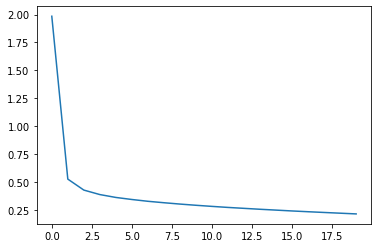

In [37]:
correct = 0
total = 0

for batch in testset:
    features, labels = batch
    o = net(features.reshape(-1,784))
    predict = []
    for x in o.data:
        predict.append(np.argmax(x))
    for b in predict == labels.data:
        if b:
            correct += 1
    total += 32
print("Accuracy %.5f"%(correct / total))

plt.plot(hist)
plt.show()